# Wavernn

### Neural Synthesizer has been proven to be way powerful than statistical synthesize, but there has been core issue of performance, this implementaion is based on a paper which helps in reducing that performance requirement

In [1]:
%matplotlib inline
#matplotlib inline provides support to render plots directly in the jupyter notebook, it gets handy

In [26]:
"""
This model has been completely developed upon tensorflow, it uses numpy and math to calculate different mathematical functions.
My initial testing includes mathematical functions due to computation overhead of sound files.

function of clear_output is to clear the consoles, comes handy
"""
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
import math

In [2]:
length=100000
sample_rate=2400
frequency=1

In [11]:
number_of_the_rnn_cells=896  #Defined in the paper
depth_of_relu_networks=896 #Defined in the paper
softmax_probability=256 #By using 256, we can level the output in terms of probability, thus better ways to analyse
number_of_layers_in_rnns=2

In [12]:
hyper_parameters={
    "batch_size":1,
    "max_sequence_length":100,
    "number_input_in_each_instant":{
        "coarse":2,
        "fine":3
    },
    "number_of_outputs":256
}

In [3]:
ful = np.sin(np.arange(length) * 2 * math.pi * frequency /sample_rate).astype(np.float32)

sine_line=np.clip(ful * 2**15, -2**15, 2**15 - 1).astype(np.int16)

sine_line=sine_line+2**15

data={
    "coarse":sine_line//256,
    "fine":sine_line%256,
}
# data['coarse'] = data['coarse']/256.0
# data['fine'] = data['fine']/256.0

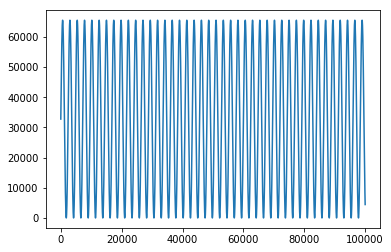

In [4]:
plt.plot(sine_line)

In [5]:
data['coarse'].max(),data['coarse'].min(),data['fine'].max(),data['fine'].min(),

(255, 0, 255, 0)

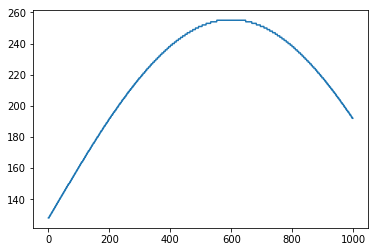

In [6]:
plt.plot(data['coarse'][sample_rate:sample_rate+1000])
plt.show()

In [7]:
X={
    "coarse":list(),
    "fine":list()
}
y={
    "coarse":list(),
    "fine":list()
}
length_of_data=len(sine_line)
for e in range(1,len(sine_line)):
    coarse_data=data['coarse']
    fine_data=data['fine']
    X['coarse'].append([coarse_data[e-1]/256.0,fine_data[e-1]/256.0])
    X['fine'].append([coarse_data[e-1]/256.0,fine_data[e-1]/256.0,coarse_data[e]/256.0])
    y['coarse'].append([coarse_data[e]])
    y['fine'].append([fine_data[e]])

In [13]:
def get_output_from_deep(type_of_input):
    probablistic_best_level=tf.nn.top_k(tf.nn.softmax(deep_layer[type_of_input]),1)[1]
    return tf.divide(probablistic_best_level,tf.constant(256))

def get_deep_layer(type_of_input):
    hidden_output=tf.nn.relu(tf.matmul(last_time_instant[type_of_input], weights['deep_layer'][type_of_input]) + bias['deep_layer'][type_of_input])
    return tf.matmul(hidden_output, weights['output_layer'][type_of_input]) + bias['output_layer'][type_of_input]


In [14]:
input_types=["coarse","fine"]

tf_input={
    "X":{},
    "y":{}
}
weights={
    "deep_layer":{
       "coarse":tf.Variable(tf.random_normal(shape=[number_of_the_rnn_cells,depth_of_relu_networks]),dtype=tf.float32),
       "fine":tf.Variable(tf.random_normal(shape=[number_of_the_rnn_cells,depth_of_relu_networks]),dtype=tf.float32)
    },
    "output_layer":{
        "coarse":tf.Variable(tf.random_normal(shape=[depth_of_relu_networks,softmax_probability]),dtype=tf.float32),
        "fine":tf.Variable(tf.random_normal(shape=[depth_of_relu_networks,softmax_probability]),dtype=tf.float32)
    }
}
bias={
    "deep_layer":{
       "coarse":tf.Variable(tf.random_normal(shape=[depth_of_relu_networks]),dtype=tf.float32),
       "fine":tf.Variable(tf.random_normal(shape=[depth_of_relu_networks]),dtype=tf.float32)
    },
    "output_layer":{
        "coarse":tf.Variable(tf.random_normal(shape=[softmax_probability]),dtype=tf.float32),
        "fine":tf.Variable(tf.random_normal(shape=[softmax_probability]),dtype=tf.float32)
    }
}

gru_cells={}
densed_gru_cells={}
raw_time_outputs={}
last_time_instant={}
deep_layer={}
output_layer={}
different_costs={}
optimizer={}

for type_of_input in input_types:
    tf_input['X'][type_of_input]=tf.placeholder(tf.float32,[hyper_parameters['batch_size'],hyper_parameters['max_sequence_length'],hyper_parameters['number_input_in_each_instant'][type_of_input]])
    tf_input['y'][type_of_input]=tf.placeholder(tf.float32,[hyper_parameters['batch_size'],hyper_parameters['number_of_outputs']])
    gru_cells[type_of_input]=[tf.contrib.rnn.GRUCell(number_of_the_rnn_cells,name=type_of_input+"_gru") for x in range(number_of_layers_in_rnns)]
    densed_gru_cells[type_of_input]=tf.contrib.rnn.MultiRNNCell(gru_cells[type_of_input])
    raw_time_outputs[type_of_input]=tf.nn.dynamic_rnn(densed_gru_cells[type_of_input],tf_input['X'][type_of_input],dtype=tf.float32)[0]
    last_time_instant[type_of_input]=tf.transpose(raw_time_outputs[type_of_input],[1,0,2])[-1]
    deep_layer[type_of_input]=get_deep_layer(type_of_input)
    output_layer[type_of_input]=get_output_from_deep(type_of_input)
    different_costs[type_of_input]=tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_input['y'][type_of_input],logits=deep_layer[type_of_input])
total_cost=sum([different_costs[type_of_input] for type_of_input in input_types])
# total_cost=different_costs['coarse']+different_costs['']
optimizer=tf.train.AdamOptimizer().minimize(total_cost)


In [15]:
tf.InteractiveSession()

In [16]:
tf.global_variables_initializer().run()

In [17]:
print(tf_input['X']['coarse'].shape)

(1, 100, 2)


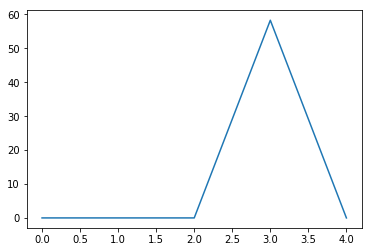

In [18]:
cost_d=[]
for e in range(5):
    starting_index=np.random.randint(length-sequence_length-2)
    X_coarse=[]
    y_coarse=[]
    X_fine=[]
    y_fine=[]
    encoding_array=np.zeros(hyper_parameters['number_of_outputs'])
    encoding_array[y['coarse'][starting_index+sequence_length-1]]=1
    X_coarse.append(np.asarray(X['coarse'][starting_index:starting_index+sequence_length]).reshape(sequence_length,2))
    y_coarse.append(encoding_array)
    encoding_array=np.zeros(hyper_parameters['number_of_outputs'])
    encoding_array[y['fine'][starting_index+sequence_length-1]]=1
    X_fine.append(np.asarray(X['fine'][starting_index:starting_index+sequence_length]).reshape(sequence_length,3))
    y_fine.append(encoding_array)
    optimizer.run(feed_dict={tf_input['X']['coarse']:X_coarse,tf_input['y']['coarse']:y_coarse,tf_input['y']['fine']:y_fine,tf_input['X']['fine']:X_fine})
    cost_in_turn=total_cost.eval(feed_dict={tf_input['X']['coarse']:X_coarse,tf_input['y']['coarse']:y_coarse,tf_input['y']['fine']:y_fine,tf_input['X']['fine']:X_fine})
    cost_d.append(cost_in_turn) 
plt.figure()
plt.plot(cost_d)
clear_output()
plt.show()

In [19]:
def coarse_and_fine_to_general(coarse,fine):
    return coarse*256+fine

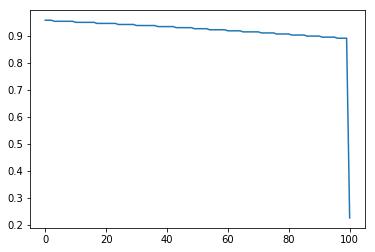

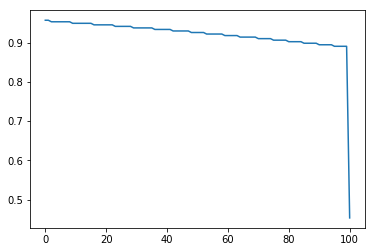

In [25]:
starting_index=np.random.randint(length-sequence_length-2)
X_coarse=np.asarray(X['coarse'][starting_index:starting_index+sequence_length]).reshape(1,sequence_length,2)
X_fine=np.asarray(X['fine'][starting_index:starting_index+sequence_length]).reshape(1,sequence_length,3)
output=[]
X_coarse=list(X_coarse.reshape(sequence_length,2))
X_fine=list(X_fine.reshape(sequence_length,3))
X_print=list([e[0] for e in X_coarse])
fine_print=list([e[2] for e in X_fine])

# for printer in range(50):
#     new_p=[]
#     new_p.append(X_input[printer:])
coarse_out=output_layer['coarse'].eval(feed_dict={tf_input['X']['coarse']:np.asarray(X_coarse).reshape((1,100,2))})
fine_out=output_layer['fine'].eval(feed_dict={tf_input['X']['fine']:np.asarray(X_fine).reshape((1,100,3))})

#     fine_out=O2.eval(feed_dict={tf_X:np.asarray(X_input[printer:]).reshape((1,500,1))})[0][0]
#     print(coarse_out,fine_out)
#     X_input.append([X_input[-1][2],X_fine[-1],coarse_out])
#     X_input.append([coarse_out])
#     X_fine.append(fine_out)
X_print.append(coarse_out)
fine_print.append(fine_out)
plt.plot(X_print)
plt.show()
plt.plot(fine_print)
# plt.legend()
plt.show()

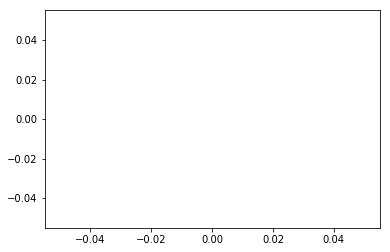

In [21]:
plt.plot(X_print[500:])

##### sample_rate=16000
input_data=None
bit_rate=np.int16
bit_width=np.iinfo(bit_rate).max
split_rate=np.uint8
split_width=np.iinfo(split_rate).max

In [22]:
filename="tt.wav"
sound32=librosa.load(filename,sr=sample_rate,mono=True,dtype=np.float128)
sound16=librosa.load(filename,sr=sample_rate,mono=True,dtype=np.float16)

NameError: name 'librosa' is not defined

In [ ]:
max=10
plt.plot(sound32[0][:max],label="32")
plt.plot(sound16[0][:max],label="16")
plt.show()

In [ ]:
print("ff") if 1 is not 0 else print("yeye")

In [ ]:
tf.__version__

In [ ]:
ddd

In [ ]:
plt.plot(fine_data[:100])

In [ ]:
first_layer=pre tf.

In [ ]:
5/4

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(cost_d)

In [ ]:
plt.plot(X_print[:500])

In [ ]:
from google.colab import files

In [ ]:
upload=files.upload()

In [ ]:
!pip3 install librosa

In [ ]:
import librosa

In [ ]:
!cd datalab/ &&ls

In [ ]:
file=librosa.load("temp.wav")

In [ ]:
file

In [ ]:
from tensorflow.python.client import device_lib


In [ ]:
local_device_protos = device_lib.list_local_devices()

In [ ]:
local_device_protos

In [ ]:
a=tf.random_normal([256])

In [ ]:
b=tf.argmax(a)

In [ ]:
a.shape

In [ ]:
a = tf.random_normal([1, 10], seed=7)
a

In [ ]:
b = tf.divide(a, tf.reduce_sum(a))
b

In [ ]:
c = tf.multinomial(b, 1)
c

In [ ]:
d = tf.gather(a, c[0][0])
d

In [ ]:
tf.InteractiveSession()

In [ ]:
tf.global_variables_initializer().run()

In [ ]:
a.eval()

In [ ]:
b.eval()

In [ ]:
c[0][0].eval()

In [ ]:
d.eval()

In [ ]:
y=13

In [ ]:
b=np.zeros(256)

In [ ]:
b[np.arange(256), 13] = 1